# Examine Antarctic profiles

Here, we take the output of the "whole domain" classification notebook (2.0) and look for classes within the Antarctic group of profiles. 

## Initial setup

### Install GSW

In [1]:
import sys
!pip install gsw

### Load modules

In [2]:
#import scikit-learn
from sklearn import mixture
from sklearn import preprocessing
from sklearn.decomposition import PCA
# import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib as mpl
# pandas for just a couple things
import pandas as pd
# for label map
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# pyxpcm, xarray, dask
import numpy as np
import xarray as xr
import datetime as dt
import random
# xgcm for vertical coordinate transforms
from xgcm import Grid
# import dask
from dask.distributed import Client
import dask
# for 3D plotting
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import seaborn as sns
# teos-10 gsw
import gsw


### Start Dask client

In [3]:
client = Client(n_workers=2, threads_per_worker=2, memory_limit='4GB')
client

<Client: 'tcp://127.0.0.1:45781' processes=2 threads=4, memory=3.88 GiB>

### Select subsetting parameters

Check for consistency with the input file

In [4]:
# plotting subset
subset = range(1000,2000,1)

lon_min = -80
lon_max =  80
lat_min = -85
lat_max = -30

# depth range
zmin = 100.0
zmax = 900.0

### Import data

In [5]:
profiles = xr.open_dataset('processed_data/profiles_80W-80E_85-30S_100-900_labeled.nc')
profiles

<xarray.Dataset>
Dimensions:        (CLASS: 5, depth: 15, profile: 185612)
Coordinates:
  * profile        (profile) int64 0 1 2 3 4 ... 185608 185609 185610 185611
    lon            (profile) float64 ...
    lat            (profile) float64 ...
  * depth          (depth) float64 100.0 120.0 140.0 160.0 ... 640.0 730.0 820.0
    time           (profile) datetime64[ns] ...
  * CLASS          (CLASS) int64 0 1 2 3 4
Data variables:
    prof_date      (profile) float64 ...
    prof_YYYYMMDD  (profile) float64 ...
    prof_HHMMSS    (profile) float64 ...
    prof_T         (profile, depth) float64 ...
    prof_S         (profile, depth) float64 ...
    label          (profile) int64 ...
    posteriors     (profile, CLASS) float64 ...

### Select Antarctic profiles

Check for consistency with notebook 2.0

In [6]:
profiles_antarctic = profiles.where(profiles.label==int(4)).dropna('profile')
profiles_antarctic

<xarray.Dataset>
Dimensions:        (CLASS: 5, depth: 15, profile: 35709)
Coordinates:
  * profile        (profile) int64 14 15 16 17 ... 185602 185603 185609 185610
    lon            (profile) float64 -26.44 -22.37 -17.38 ... 51.89 64.79 35.28
    lat            (profile) float64 -55.98 -56.81 -57.51 ... -58.72 -60.98
  * depth          (depth) float64 100.0 120.0 140.0 160.0 ... 640.0 730.0 820.0
    time           (profile) datetime64[ns] 1973-01-11T12:00:00 ... 2017-08-2...
  * CLASS          (CLASS) int64 0 1 2 3 4
Data variables:
    prof_date      (profile) float64 7.206e+05 7.206e+05 ... 7.369e+05 7.369e+05
    prof_YYYYMMDD  (profile) float64 1.973e+07 1.973e+07 ... 2.017e+07 2.017e+07
    prof_HHMMSS    (profile) float64 1.2e+05 1.2e+05 1.2e+05 ... 8.4e+04 1.4e+04
    prof_T         (profile, depth) float64 -1.228 -0.9877 ... 1.167 1.067
    prof_S         (profile, depth) float64 34.2 34.25 34.33 ... 34.73 34.72
    label          (profile) float64 4.0 4.0 4.0 4.0 4.0 ... 4.0 4.0 4.0 4.0 4.0
    posteriors     (profile, CLASS) float64 1.969e-45 3.878e-168 ... 1.0

### Calculate density (sig0)

In [7]:
# idea to use xr.apply_ufunc():
# https://discourse.pangeo.io/t/wrapped-for-dask-teos-10-gibbs-seawater-gsw-oceanographic-toolbox/466/2?u=dan_jones

pt = profiles_antarctic.prof_T
sp = profiles_antarctic.prof_S
p = profiles_antarctic.depth
lon = profiles_antarctic.lon
lat = profiles_antarctic.lat

sa = xr.apply_ufunc(gsw.SA_from_SP, sp, p, lon, lat, dask='parallelized', output_dtypes=[sp.dtype])
ct = xr.apply_ufunc(gsw.CT_from_pt, sa, pt)
sig0 = xr.apply_ufunc(gsw.density.sigma0, sa, ct)

# add sig0 to existinng profiles_antarctic dataset
profiles_antarctic['sig0'] = sig0
profiles_antarctic['prof_SA'] = sa
profiles_antarctic['prof_CT'] = ct

## Data visualization and exploration

### Plot temperature profiles

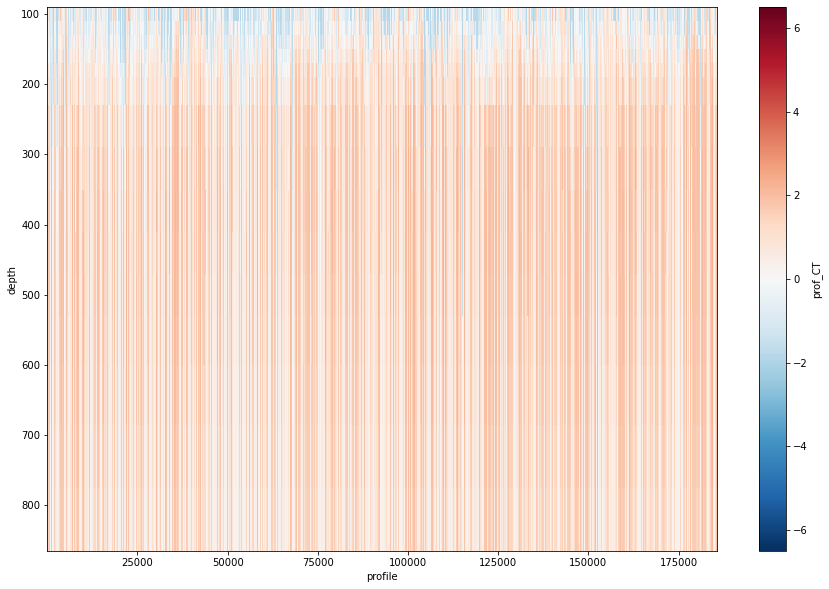

In [8]:
fig, ax = plt.subplots(figsize=(15,10))
profiles_antarctic.prof_CT.plot(y='depth', yincrease=False)

### Plot salinity profiles

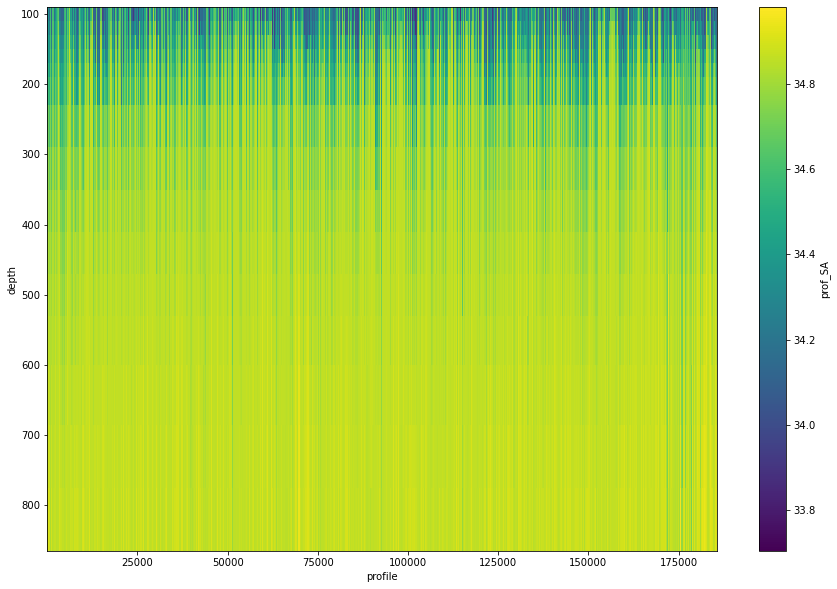

In [9]:
fig, ax = plt.subplots(figsize=(15,10))
profiles_antarctic.prof_SA.plot(y='depth', yincrease=False)

### Plot density profiles

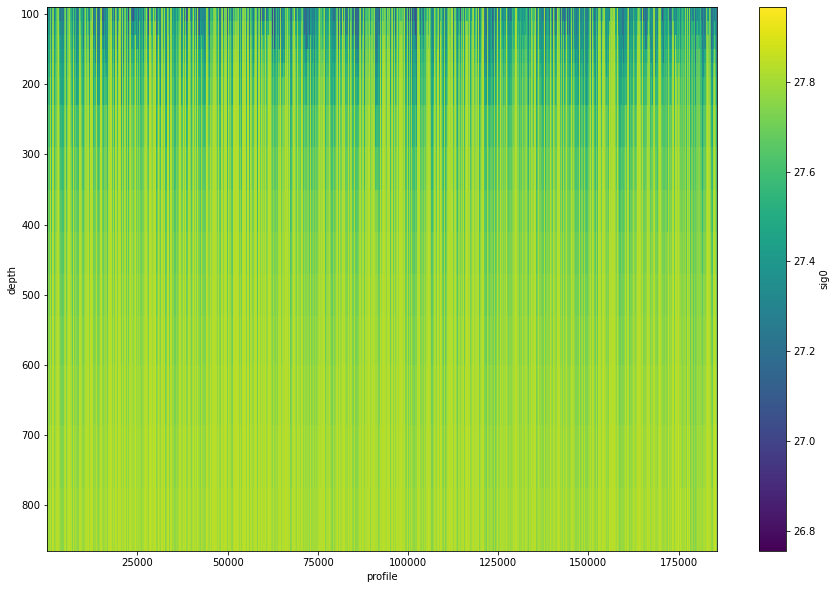

In [10]:
fig, ax = plt.subplots(figsize=(15,10))
profiles_antarctic.sig0.plot(y='depth', yincrease=False)

### Plot temperature histogram 

(array([3.57530e+04, 4.44400e+04, 1.59977e+05, 1.46309e+05, 1.48755e+05,
        3.85000e+02, 1.00000e+01, 4.00000e+00, 0.00000e+00, 2.00000e+00]),
 array([-1.95692634, -1.11190676, -0.26688719,  0.57813239,  1.42315197,
         2.26817154,  3.11319112,  3.95821069,  4.80323027,  5.64824985,
         6.49326942]),
 <BarContainer object of 10 artists>)

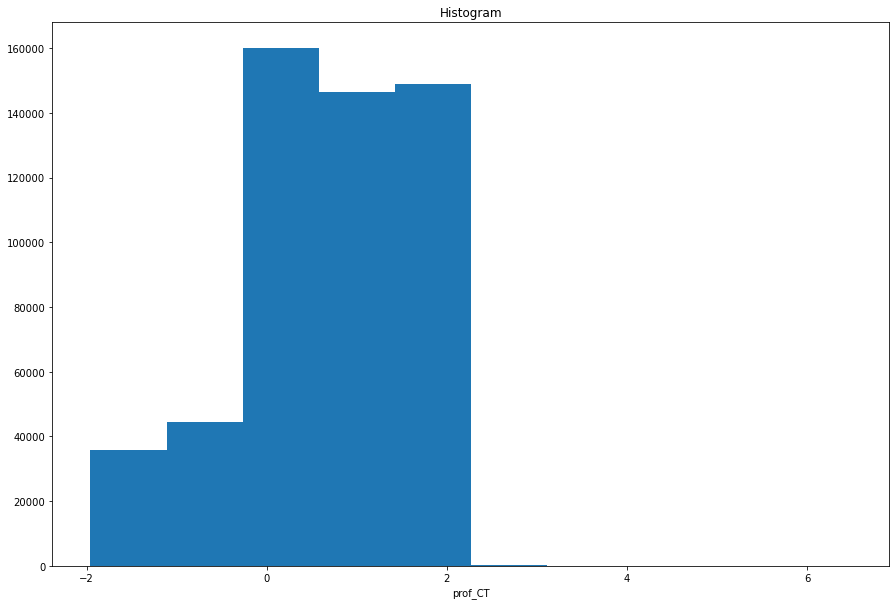

In [11]:
xr.plot.hist(profiles_antarctic.prof_CT,figsize=(15,10))

### Plot salinity histogram 

(array([5.70000e+01, 8.21000e+02, 4.82200e+03, 1.67560e+04, 2.28460e+04,
        3.09570e+04, 4.30210e+04, 6.50400e+04, 1.73914e+05, 1.77401e+05]),
 array([33.70461853, 33.83208573, 33.95955293, 34.08702014, 34.21448734,
        34.34195454, 34.46942174, 34.59688894, 34.72435614, 34.85182335,
        34.97929055]),
 <BarContainer object of 10 artists>)

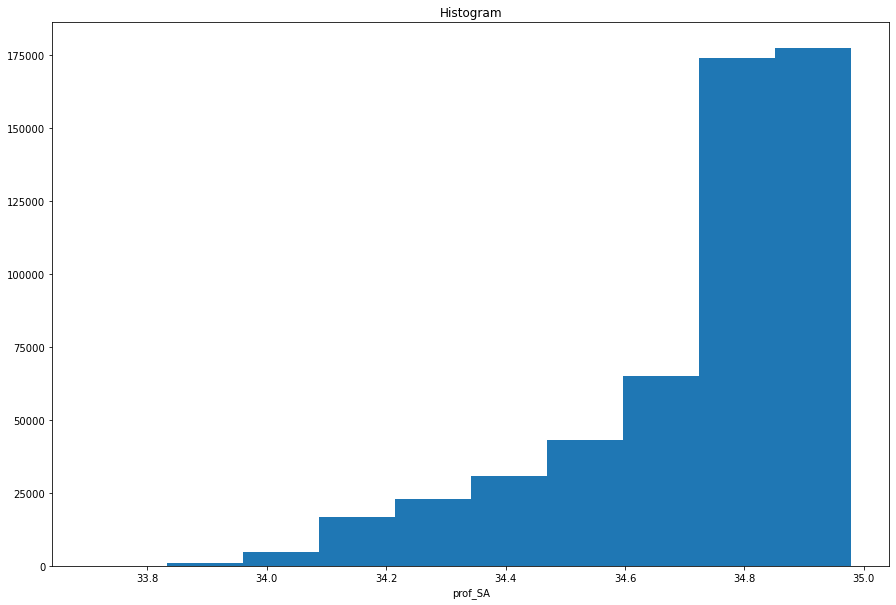

In [12]:
xr.plot.hist(profiles_antarctic.prof_SA,figsize=(15,10))

### Plot sig0 histogram

(array([4.00000e+00, 7.70000e+01, 1.03000e+03, 5.27100e+03, 1.83450e+04,
        3.47360e+04, 5.21050e+04, 1.05978e+05, 3.14470e+05, 3.61900e+03]),
 array([26.75497812, 26.87617029, 26.99736247, 27.11855465, 27.23974682,
        27.360939  , 27.48213118, 27.60332335, 27.72451553, 27.84570771,
        27.96689989]),
 <BarContainer object of 10 artists>)

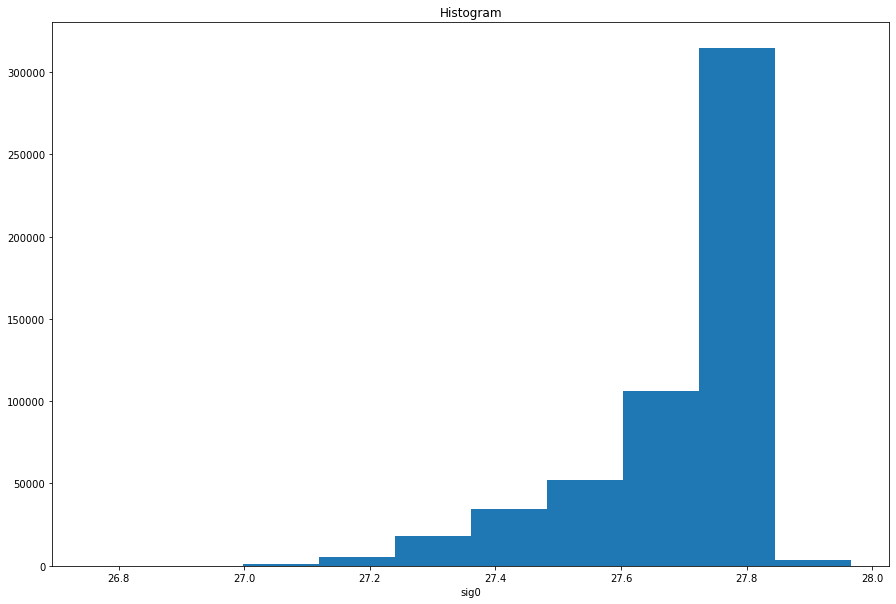

In [13]:
xr.plot.hist(profiles_antarctic.sig0,figsize=(15,10))

### Regrid T/S onto density surfaces

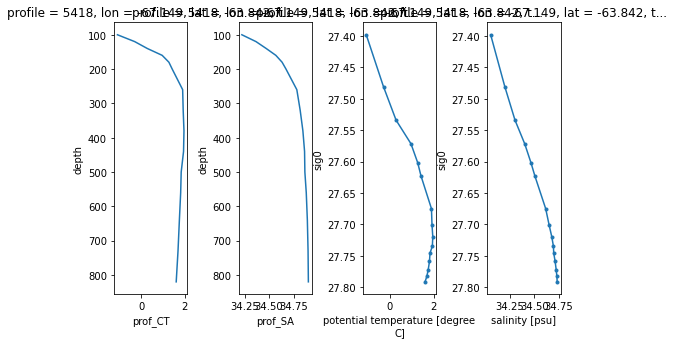

In [14]:
df = profiles_antarctic.isel(profile=2000)

def plot_profile():
   fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=[8,5])
   df.prof_CT.plot(ax=ax1, y='depth', yincrease=False)
   df.prof_SA.plot(ax=ax2, y='depth', yincrease=False)
   df.swap_dims({'depth': 'sig0'}).prof_T.plot(ax=ax3, y='sig0', marker='.', yincrease=False)
   df.swap_dims({'depth': 'sig0'}).prof_S.plot(ax=ax4, y='sig0', marker='.', yincrease=False)
   fig.subplots_adjust(wspace=0.7)
   return ax4

plot_profile();

In [15]:
# Idea for transformation into new vertical coordinates: https://xgcm.readthedocs.io/en/latest/transform.html

grid = Grid(profiles_antarctic, coords={'Z': {'center': 'depth'}}, periodic=False)
target_sig0_levels = np.linspace(27.4, 27.8, 8)

# linearly interpolate temperature onto selected sig0 levels
theta_on_sig0 = grid.transform(profiles_antarctic.prof_CT, 'Z', 
                               target_sig0_levels, 
                               target_data=profiles_antarctic.sig0, 
                               method='linear')

# linearly interpolate salt onto selected sig0 levels
salt_on_sig0 = grid.transform(profiles_antarctic.prof_SA, 'Z', 
                              target_sig0_levels, 
                              target_data=profiles_antarctic.sig0, 
                              method='linear')

# rename to avoid conflict with sig0 variable
theta_on_sig0 = theta_on_sig0.rename({'sig0':'sig0_levs'})
salt_on_sig0 = salt_on_sig0.rename({'sig0':'sig0_levs'})

# add to existing dataset
profiles_antarctic['theta_on_sig0'] = theta_on_sig0
profiles_antarctic['salt_on_sig0'] = salt_on_sig0
profiles_antarctic

<xarray.Dataset>
Dimensions:        (CLASS: 5, depth: 15, profile: 35709, sig0_levs: 8)
Coordinates:
  * profile        (profile) int64 14 15 16 17 ... 185602 185603 185609 185610
    lon            (profile) float64 -26.44 -22.37 -17.38 ... 51.89 64.79 35.28
    lat            (profile) float64 -55.98 -56.81 -57.51 ... -58.72 -60.98
  * depth          (depth) float64 100.0 120.0 140.0 160.0 ... 640.0 730.0 820.0
    time           (profile) datetime64[ns] 1973-01-11T12:00:00 ... 2017-08-2...
  * CLASS          (CLASS) int64 0 1 2 3 4
  * sig0_levs      (sig0_levs) float64 27.4 27.46 27.51 ... 27.69 27.74 27.8
Data variables:
    prof_date      (profile) float64 7.206e+05 7.206e+05 ... 7.369e+05 7.369e+05
    prof_YYYYMMDD  (profile) float64 1.973e+07 1.973e+07 ... 2.017e+07 2.017e+07
    prof_HHMMSS    (profile) float64 1.2e+05 1.2e+05 1.2e+05 ... 8.4e+04 1.4e+04
    prof_T         (profile, depth) float64 -1.228 -0.9877 ... 1.167 1.067
    prof_S         (profile, depth) float64 34.2 34.25 34.33 ... 34.73 34.72
    label          (profile) float64 4.0 4.0 4.0 4.0 4.0 ... 4.0 4.0 4.0 4.0 4.0
    posteriors     (profile, CLASS) float64 1.969e-45 3.878e-168 ... 1.0
    sig0           (profile, depth) float64 27.52 27.55 27.6 ... 27.82 27.82
    prof_SA        (profile, depth) float64 34.36 34.41 34.49 ... 34.9 34.89
    prof_CT        (profile, depth) float64 -1.225 -0.9843 ... 1.167 1.067
    theta_on_sig0  (profile, sig0_levs) float64 nan nan nan ... 1.421 1.43
    salt_on_sig0   (profile, sig0_levs) float64 nan nan nan ... 34.82 34.89

### Drop density levels and profiles with NaN values

In [16]:
profiles_antarctic_onSig = profiles_antarctic.dropna(dim='sig0_levs',how='all')
profiles_antarctic_onSig = profiles_antarctic.dropna(dim='profile', how='any')
profiles_antarctic_onSig

<xarray.Dataset>
Dimensions:        (CLASS: 5, depth: 15, profile: 4000, sig0_levs: 8)
Coordinates:
  * profile        (profile) int64 15 348 385 386 ... 185516 185522 185528
    lon            (profile) float64 -22.37 18.23 -30.41 ... 46.07 46.37 46.93
    lat            (profile) float64 -56.81 -58.44 -53.91 ... -55.29 -55.21
  * depth          (depth) float64 100.0 120.0 140.0 160.0 ... 640.0 730.0 820.0
    time           (profile) datetime64[ns] 1973-01-17T12:00:00 ... 2017-07-1...
  * CLASS          (CLASS) int64 0 1 2 3 4
  * sig0_levs      (sig0_levs) float64 27.4 27.46 27.51 ... 27.69 27.74 27.8
Data variables:
    prof_date      (profile) float64 7.206e+05 7.221e+05 ... 7.369e+05 7.369e+05
    prof_YYYYMMDD  (profile) float64 1.973e+07 1.977e+07 ... 2.017e+07 2.017e+07
    prof_HHMMSS    (profile) float64 1.2e+05 2.3e+04 7e+04 ... 8.5e+04 1.7e+05
    prof_T         (profile, depth) float64 -0.6127 -0.6594 ... 1.522 1.478
    prof_S         (profile, depth) float64 33.96 34.01 34.06 ... 34.73 34.74
    label          (profile) float64 4.0 4.0 4.0 4.0 4.0 ... 4.0 4.0 4.0 4.0 4.0
    posteriors     (profile, CLASS) float64 1.091e-38 6.089e-144 ... 0.9381
    sig0           (profile, depth) float64 27.3 27.34 27.38 ... 27.8 27.81
    prof_SA        (profile, depth) float64 34.12 34.17 34.22 ... 34.9 34.91
    prof_CT        (profile, depth) float64 -0.6084 -0.6552 ... 1.522 1.477
    theta_on_sig0  (profile, sig0_levs) float64 -0.5568 -0.439 ... 1.689 1.523
    salt_on_sig0   (profile, sig0_levs) float64 34.25 34.33 34.41 ... 34.85 34.9

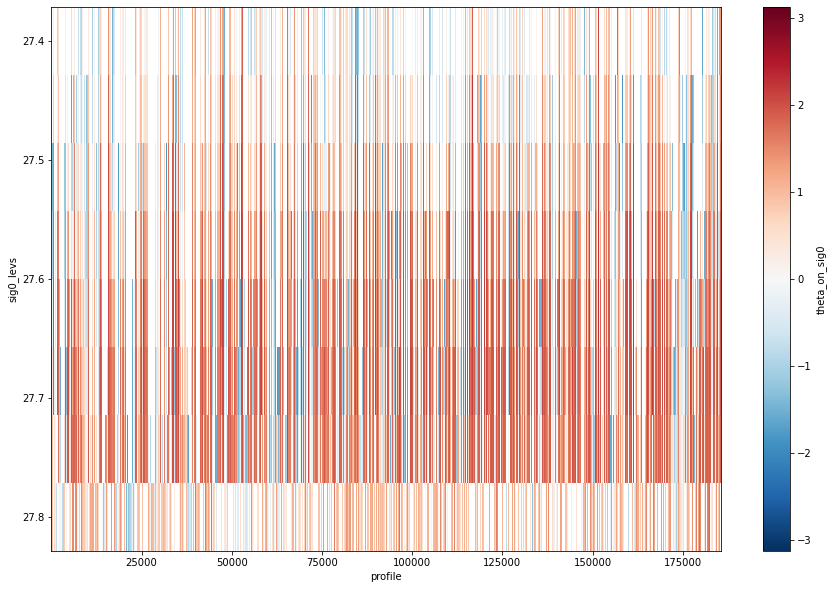

In [17]:
fig, ax = plt.subplots(figsize=(15,10))
profiles_antarctic.theta_on_sig0.plot(y='sig0_levs', yincrease=False)

### Apply unsupervised classification method

### Preprocessing, scaling, and dimensionality reduction

In [18]:
# scale salinity
X = profiles_antarctic.prof_SA
#X = profiles_antarctic_onSig.salt_on_sig0
scaled_S = preprocessing.scale(X)
scaled_S.shape

# scale temperature
X = profiles_antarctic.prof_CT
#X = profiles_antarctic_onSig.theta_on_sig0
scaled_T = preprocessing.scale(X)
scaled_T.shape

# concatenate 
Xscaled = np.concatenate((scaled_T,scaled_S),axis=1)

# create PCA object
pca = PCA(n_components=8)

# fit PCA model
pca.fit(Xscaled)

# transform input data into PCA representation
Xpca = pca.transform(Xscaled)

# add PCA values to the profiles Dataset
PCA1 = xr.DataArray(Xpca[:,0],dims='profile')
PCA2 = xr.DataArray(Xpca[:,1],dims='profile')
PCA3 = xr.DataArray(Xpca[:,2],dims='profile')

# calculated total variance explained
total_variance_explained_ = np.sum(pca.explained_variance_ratio_) 
total_variance_explained_

0.9848714692665556

### Use BIC and AIC to inform number of classes

In [19]:
# select parameters
max_N = 20     # the maximum number of classes to try 
max_bic_iter = 20  # the maximum number of iterations for BIC
max_aic_iter = max_bic_iter  # the maximum number of iterations for AIC

# initialize, declare variables
bic_scores = np.zeros((2,max_bic_iter))
aic_scores = np.zeros((2,max_aic_iter))

# loop through the maximum number of classes, estimate BIC
n_components_range = range(2, max_N)
bic_iter_range = range(0,max_bic_iter)
aic_iter_range = range(0,max_aic_iter)

# iterate through all the covariance types (just 'full' for now)
cv_types = ['full']

# loop through cv_types, components, and iterations
for cv_type in cv_types:
    # iterate over all the possible numbers of components
    for n_components in n_components_range:
        bic_one = []
        aic_one = []
        # repeat the BIC step for better statistics
        for bic_iter in bic_iter_range:
            # select a new random subset
            rows_id = random.sample(range(0,Xpca.shape[0]-1), 1000)
            Xpca_for_BIC = Xpca[rows_id,:]
            # fit a Gaussian mixture model
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type,
                                          random_state=42)

            # uncomment for 'rapid' BIC fitting
            gmm.fit(Xpca_for_BIC)

            # append this BIC score to the list
            bic_one.append(gmm.bic(Xpca_for_BIC))
            aic_one.append(gmm.aic(Xpca_for_BIC))
            Xpca_for_BIC = []
            Xpca_for_AIC = []

        # stack the bic scores into a single 2D structure
        bic_scores = np.vstack((bic_scores, np.asarray(bic_one)))
        aic_scores = np.vstack((aic_scores, np.asarray(aic_one)))

# the first two rows are not needed; they were only placeholders
bic_scores = bic_scores[2:,:]
aic_scores = aic_scores[2:,:]

# mean values for BIC and AIC
bic_mean = np.mean(bic_scores, axis=1)
aic_mean = np.mean(aic_scores, axis=1)

# standard deviation for BIC and AIC
bic_std = np.std(bic_scores, axis=1)
aic_std = np.std(aic_scores, axis=1)

Text(0, 0.5, 'BIC score')

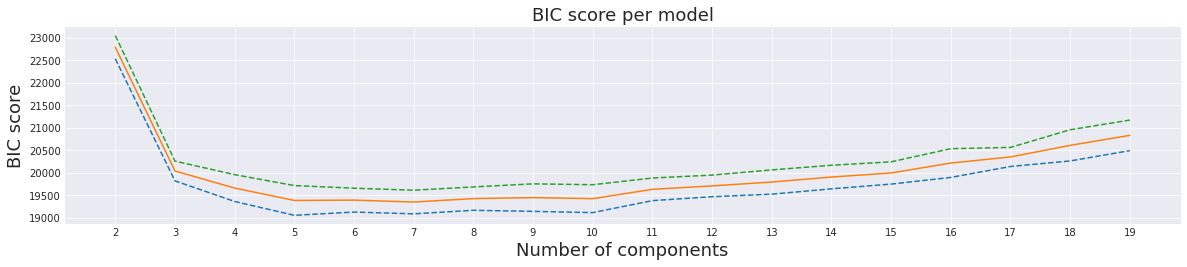

In [20]:
# plot the BIC scores
plt.figure(figsize=(20, 8))
plt.style.use('seaborn-darkgrid')
spl = plt.subplot(2, 1, 1)
plt.plot(n_components_range, bic_mean-bic_std, '--')  
plt.plot(n_components_range, bic_mean, '-')  
plt.plot(n_components_range, bic_mean+bic_std, '--')  
plt.xticks(n_components_range)
#plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model', fontsize=18)
spl.set_xlabel('Number of components',fontsize=18)
spl.set_ylabel('BIC score',fontsize=18)
#plt.show()

Interestingly, there is a minimum between 5-9. We'll opt for the smaller number for ease of interpretation. 

### Plot the AIC scores

Text(0, 0.5, 'AIC score')

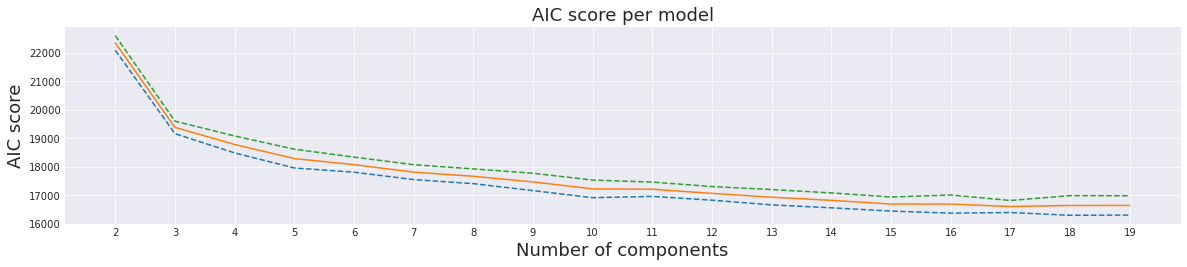

In [21]:
# plot the AIC scores
plt.figure(figsize=(20, 8))
plt.style.use('seaborn-darkgrid')
spl = plt.subplot(2, 1, 1)
plt.plot(n_components_range, aic_mean-aic_std, '--')  
plt.plot(n_components_range, aic_mean, '-')  
plt.plot(n_components_range, aic_mean+aic_std, '--')  
plt.xticks(n_components_range)
plt.title('AIC score per model', fontsize=18)
spl.set_xlabel('Number of components',fontsize=18)
spl.set_ylabel('AIC score',fontsize=18)
#plt.show()

### Apply selected GMM

In [22]:
# set variables
n_components_selected = 5

# establish gmm
best_gmm = mixture.GaussianMixture(n_components=n_components_selected,
                                   covariance_type='full',
                                   random_state=42)

# fit this GMM
best_gmm.fit(Xpca)

# check to make sure that n_comp is as expected
n_comp = gmm.n_components

# select colormap
colormap = plt.get_cmap('tab10', n_comp)

# assign class labels ("predict" the class using the selected GMM)
labels = best_gmm.predict(Xpca)

# find posterior probabilities (the probabilities of belonging to each class)
posterior_probs = best_gmm.predict_proba(Xpca)

# maximum posterior probability (the class is assigned based on this value)
max_posterior_probs = np.max(posterior_probs,axis=1) 

# put the labels and maximum posterior probabilities back in original dataframe
#df.insert(3,'label',labels,True)
#df.insert(4,'max posterior prob',max_posterior_probs,True) 

# print out best_gmm parameters
#posterior_probs.shape

# convert labels into xarray format
xlabels = xr.DataArray(labels, coords=[profiles_antarctic.profile], dims='profile')

# convert posterior probabilities into xarray format
gmm_classes = [b for b in range(0,n_components_selected,1)]
xprobs = xr.DataArray(posterior_probs, 
                      coords=[profiles_antarctic.profile, gmm_classes], 
                      dims=['profile', 'CLASS'])

# add label DataArray to Dataset
profiles_antarctic = profiles_antarctic.assign({'label':xlabels})
profiles_antarctic = profiles_antarctic.assign({'posteriors':xprobs})

## Plot GMM results

### Calculate class means

In [23]:
# create grouped object using the labels
grouped = profiles_antarctic.groupby("label")

# class means and standard deviations
class_means = grouped.mean()
class_stds = grouped.std()

# visualize grouped dataset
#class_means

### Plot vertical structure of class means: temperature 

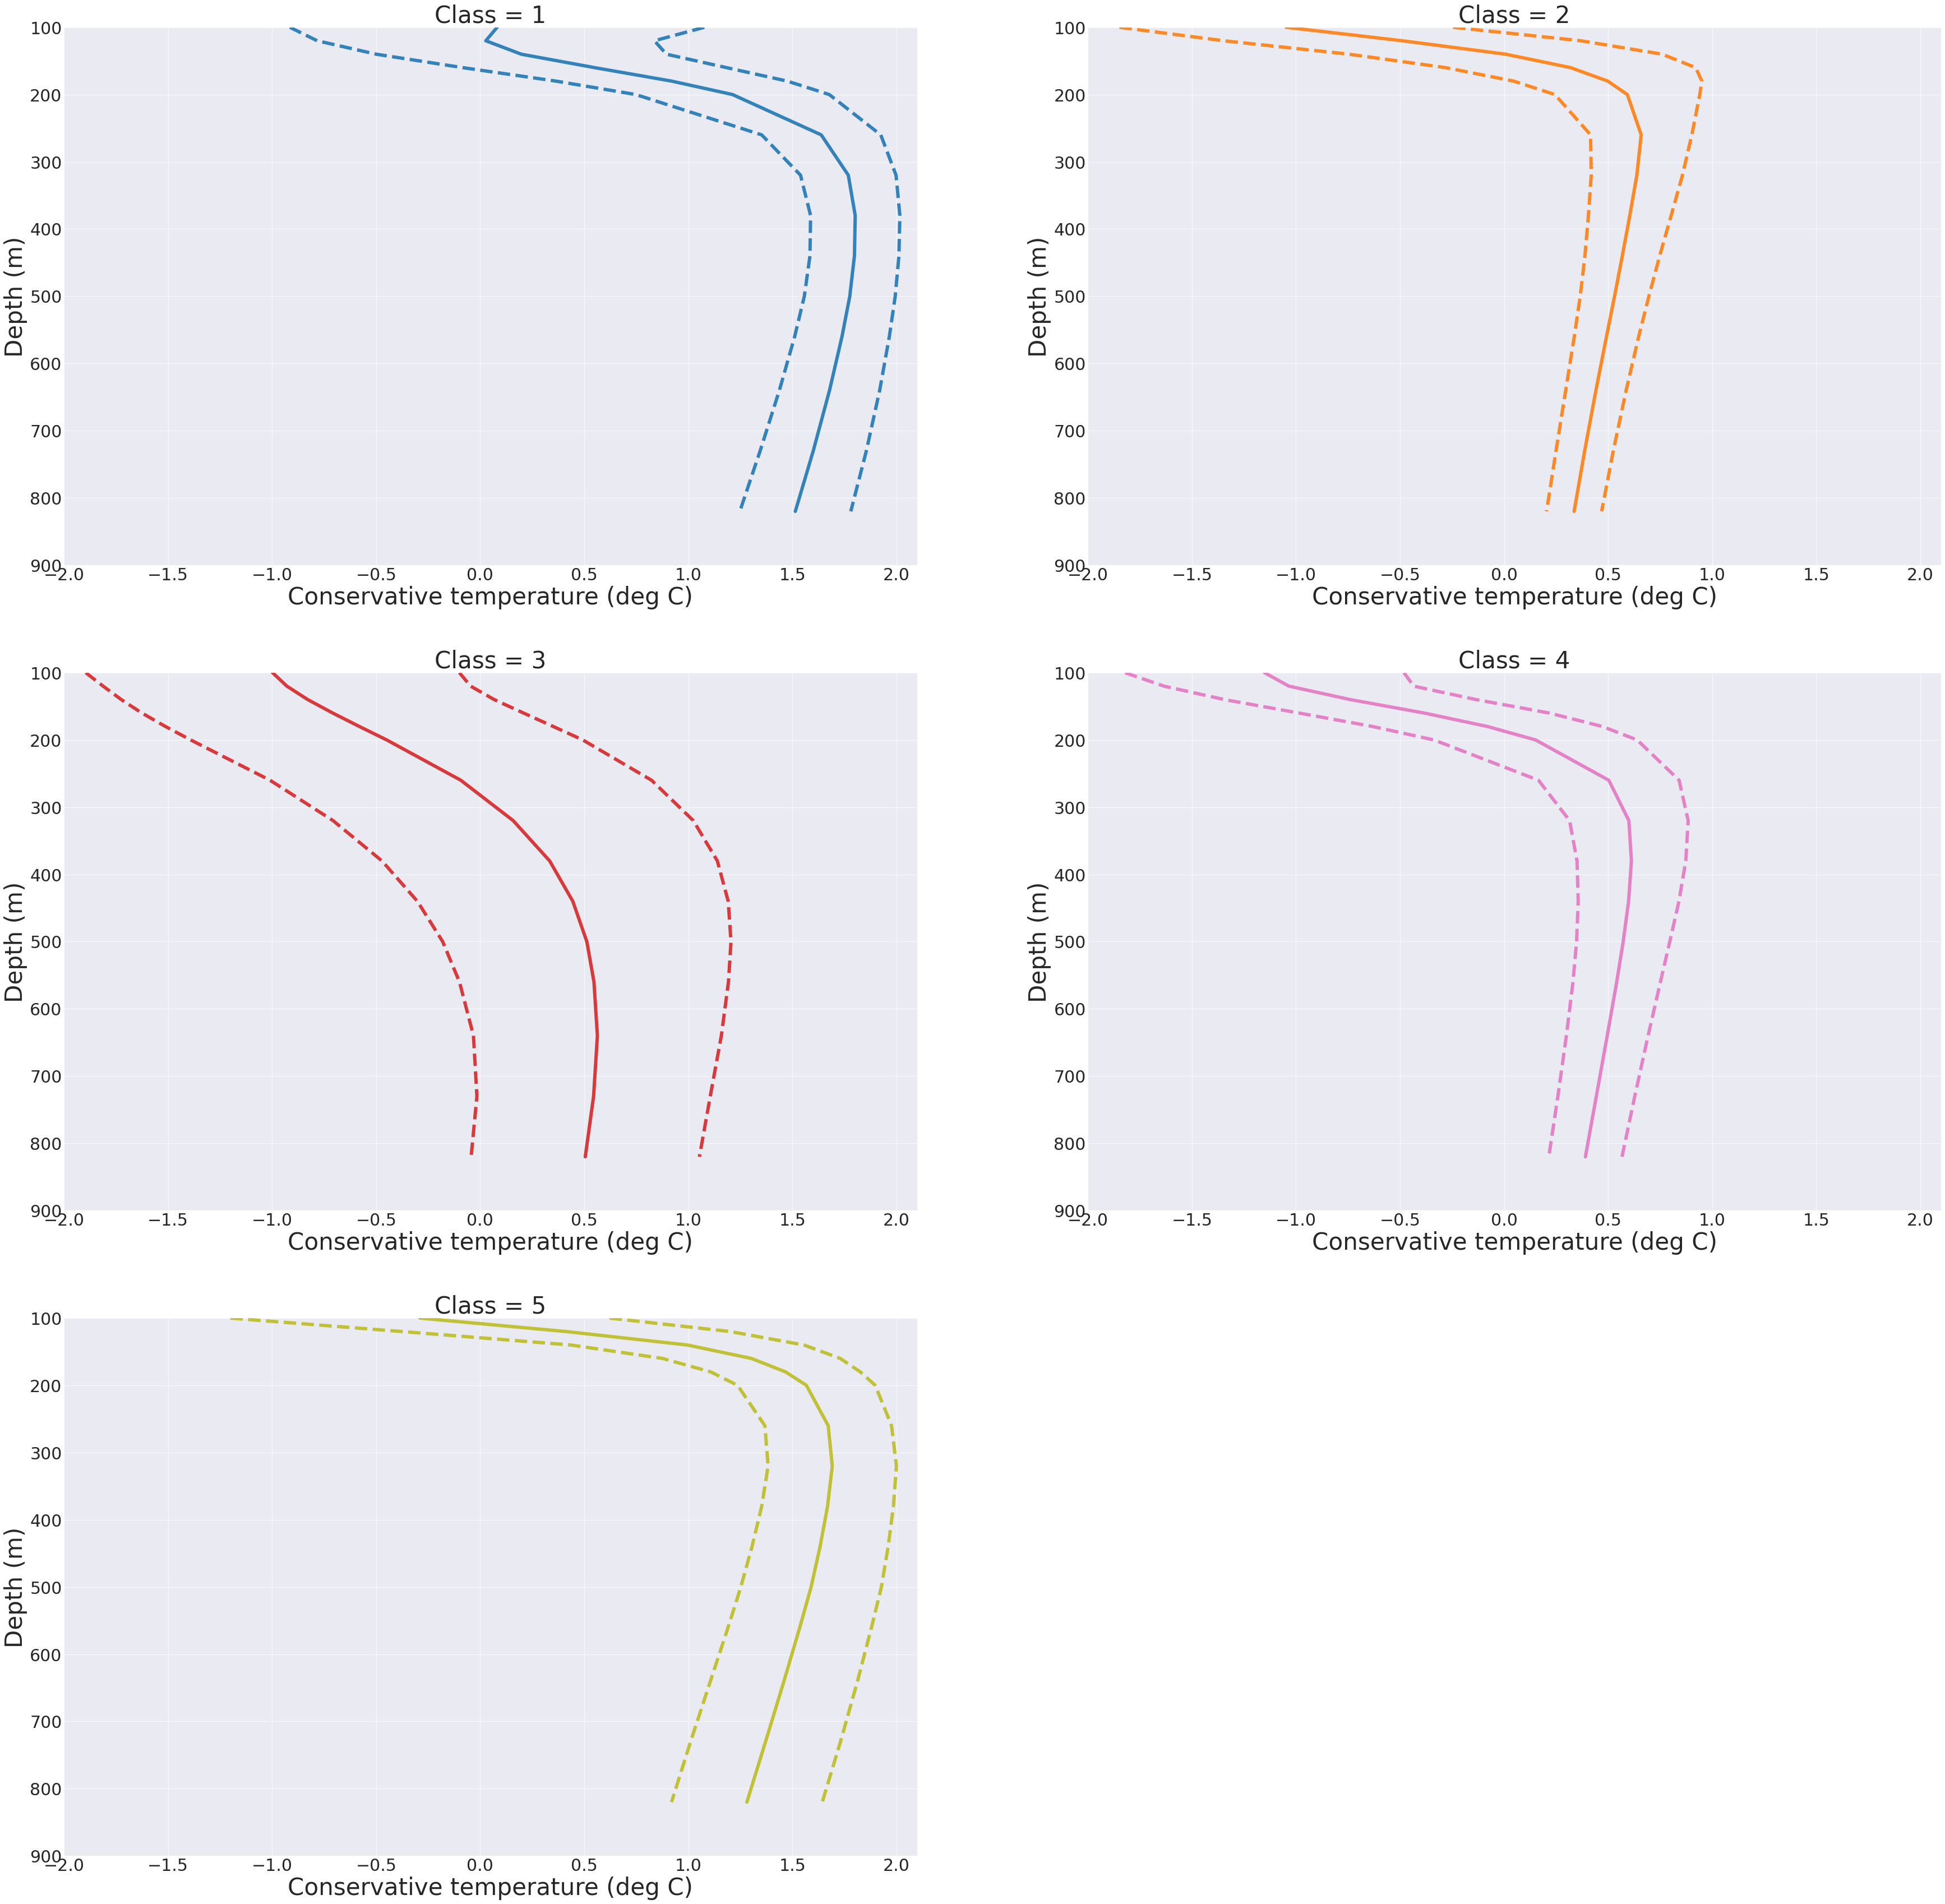

In [24]:
cNorm = colors.Normalize(vmin=0, vmax=n_components_selected)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=colormap)

# initialize the figure
plt.figure(figsize=(60, 60))
plt.style.use('seaborn-darkgrid')
#palette = cmx.Paired(np.linspace(0,1,n_comp))
 
# vertical coordinate
z = profiles.depth.values    
    
# iterate over groups
num = 0
for nrow in range(0,n_components_selected):
    num += 1
    colorVal = scalarMap.to_rgba(nrow)
    
    # extract means
    mean_T = class_means.prof_CT[nrow,:].values
    
    # extract stdevs
    std_T = class_stds.prof_CT[nrow,:].values
    
    # select subplot
    ax = plt.subplot(3,2,num)
    plt.plot(mean_T, z, marker='', linestyle='solid', color=colorVal, linewidth=6.0, alpha=0.9)
    plt.plot(mean_T+std_T, z, marker='', linestyle='dashed', color=colorVal, linewidth=6.0, alpha=0.9)
    plt.plot(mean_T-std_T, z, marker='', linestyle='dashed', color=colorVal, linewidth=6.0, alpha=0.9)
    
    # custom grid and axes
    plt.ylim([zmin,zmax])
    plt.xlim([-2, 2.1])
    
   #text box
    fs = 42 # font size
    plt.xlabel('Conservative temperature (deg C)', fontsize=fs)
    plt.ylabel('Depth (m)', fontsize=fs)
    plt.title('Class = ' + str(num), fontsize=fs)
    
    # font and axis stuff
    plt.gca().invert_yaxis()
    ax.tick_params(axis='x', labelsize=30)
    ax.tick_params(axis='y', labelsize=30)

### Plot vertical structure of class means: salinity

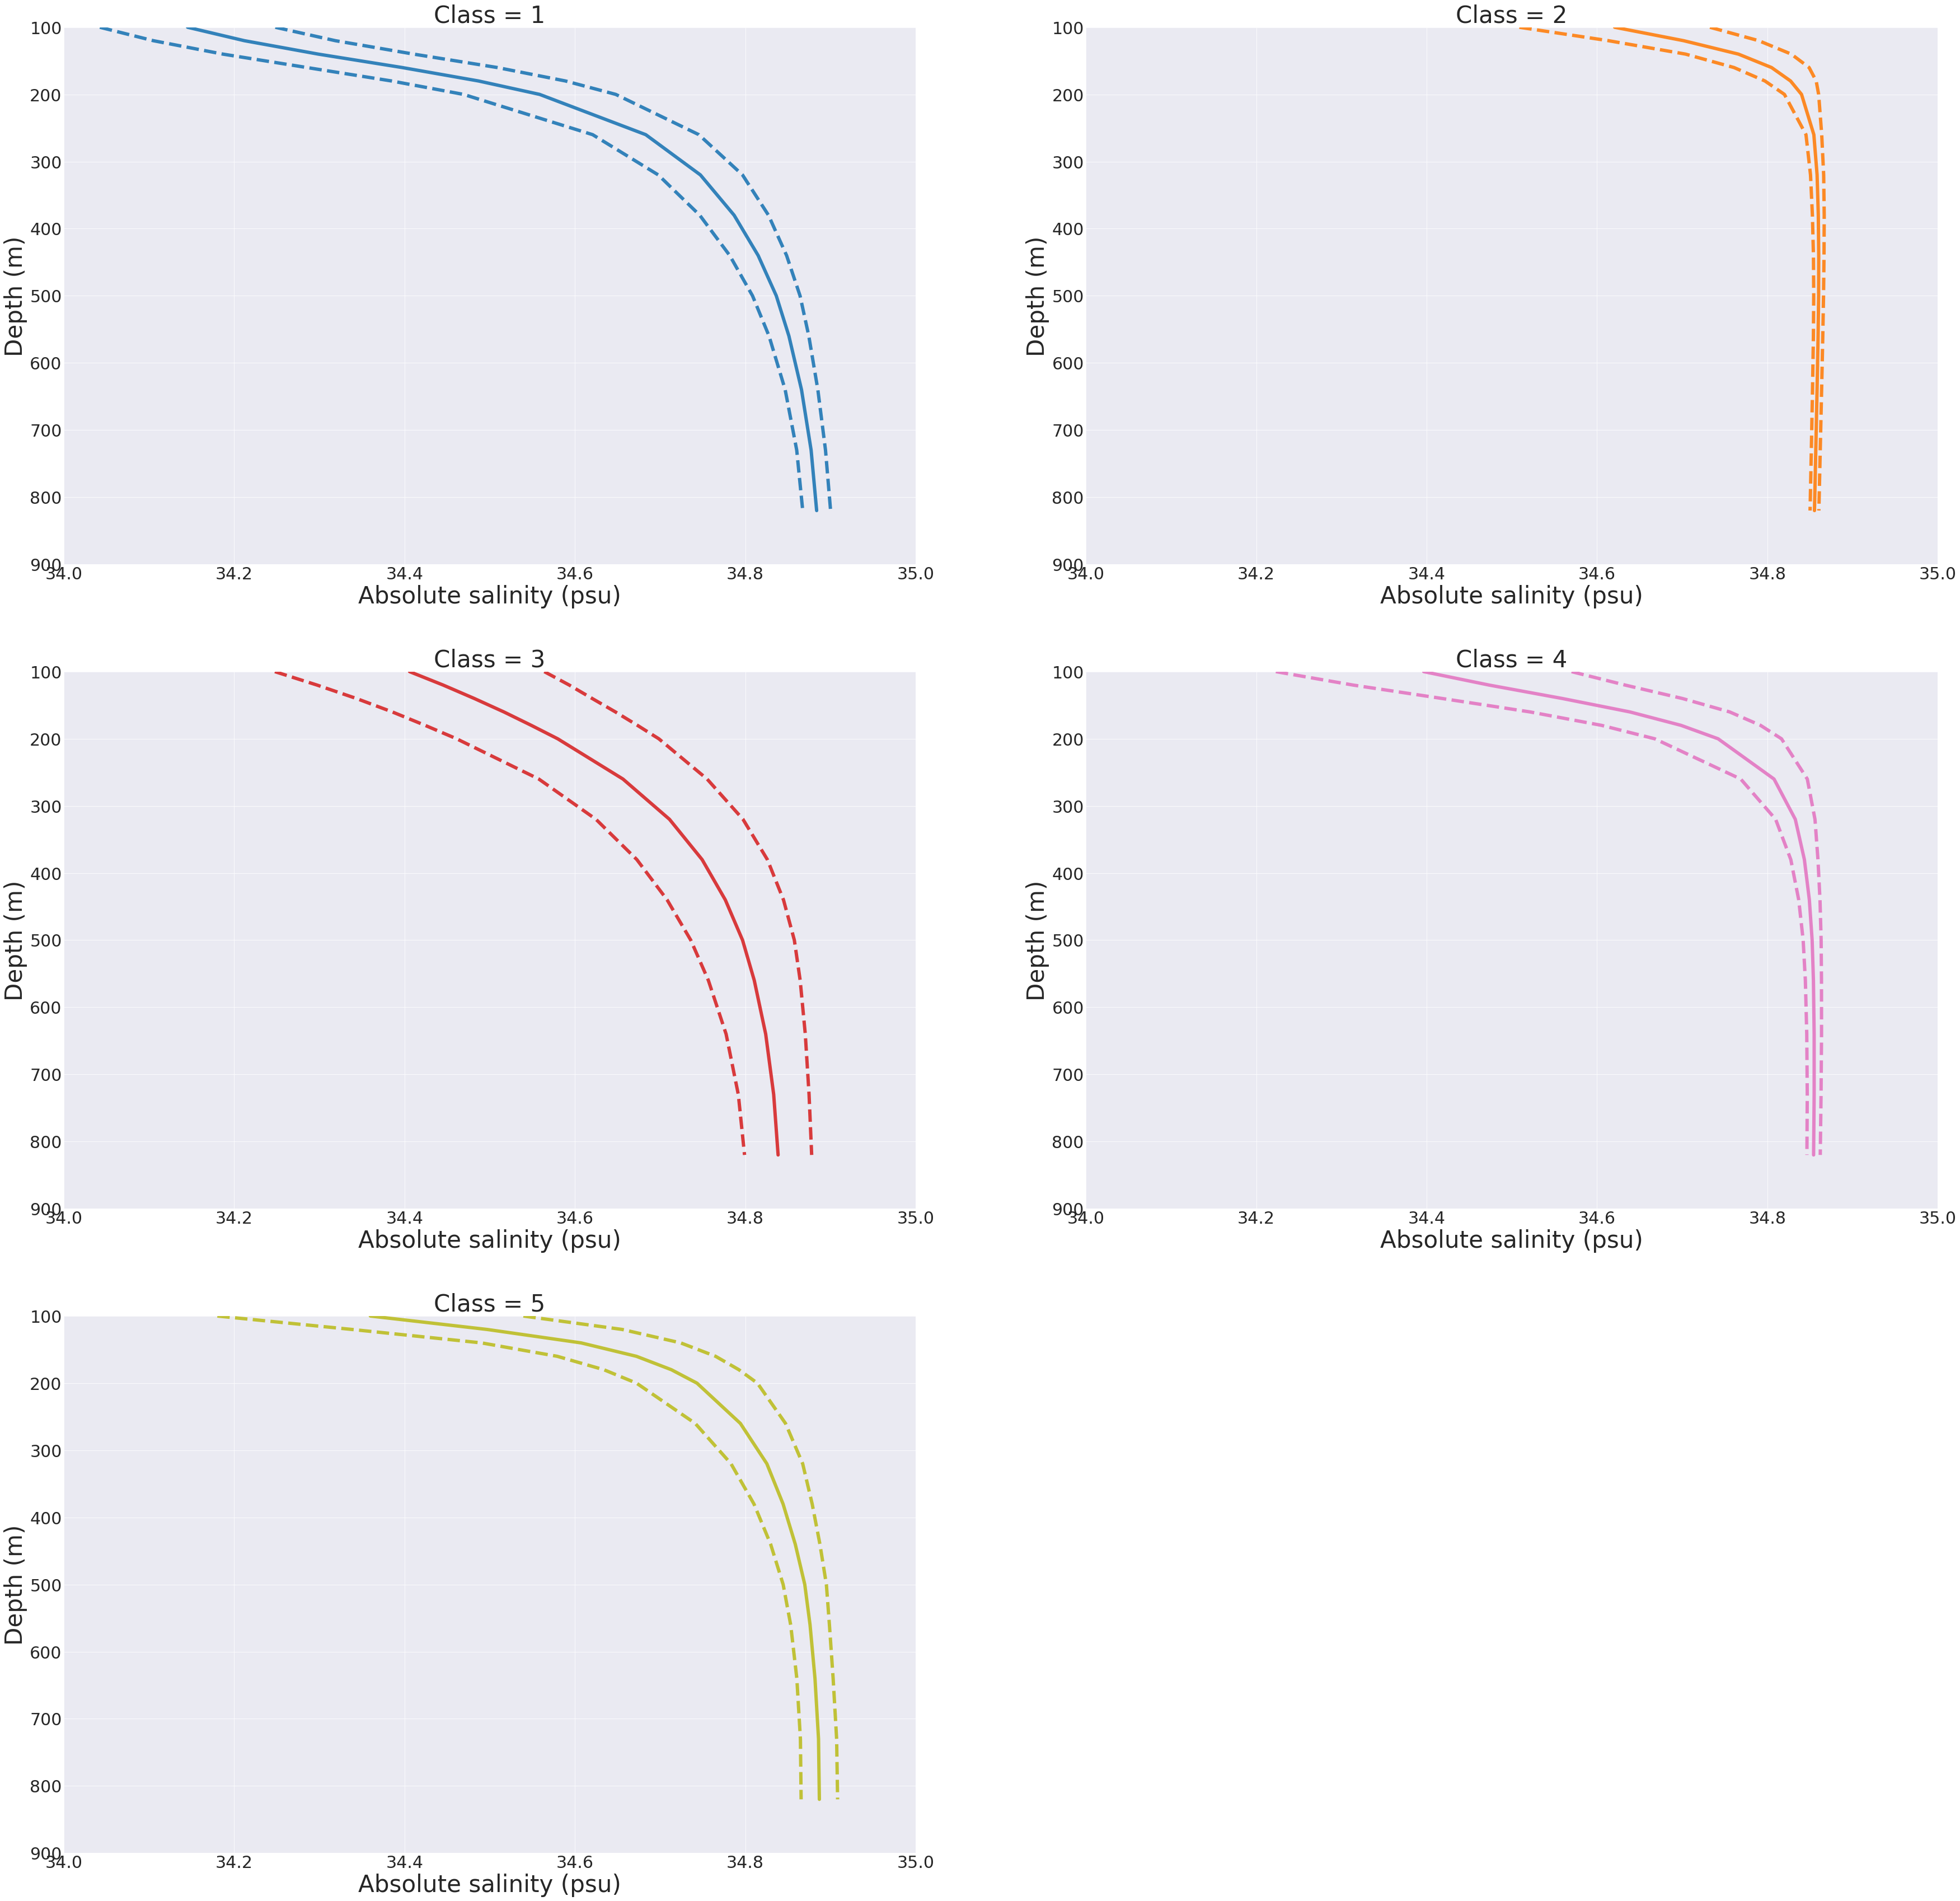

In [25]:
cNorm = colors.Normalize(vmin=0, vmax=n_components_selected)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=colormap)

# initialize the figure
plt.figure(figsize=(60, 60))
plt.style.use('seaborn-darkgrid')
#palette = cmx.Paired(np.linspace(0,1,n_comp))
 
# vertical coordinate
z = profiles_antarctic.depth.values    
    
# iterate over groups
num = 0
for nrow in range(0,n_components_selected):
    num += 1
    colorVal = scalarMap.to_rgba(nrow)
    
    # extract means
    mean_S = class_means.prof_SA[nrow,:].values
    
    # extract stdevs
    std_S = class_stds.prof_SA[nrow,:].values
    
    # select subplot
    ax = plt.subplot(3,2,num)
    plt.plot(mean_S, z, marker='', linestyle='solid', color=colorVal, linewidth=6.0, alpha=0.9)
    plt.plot(mean_S+std_S, z, marker='', linestyle='dashed', color=colorVal, linewidth=6.0, alpha=0.9)
    plt.plot(mean_S-std_S, z, marker='', linestyle='dashed', color=colorVal, linewidth=6.0, alpha=0.9)
    
    # custom grid and axes
    plt.ylim([zmin, zmax])
    plt.xlim([34.0, 35.0])
    
   #text box
    fs = 42 # font size
    plt.xlabel('Absolute salinity (psu)', fontsize=fs)
    plt.ylabel('Depth (m)', fontsize=fs)
    plt.title('Class = ' + str(num), fontsize=fs)
    
    # font and axis stuff
    plt.gca().invert_yaxis()
    ax.tick_params(axis='x', labelsize=30)
    ax.tick_params(axis='y', labelsize=30)
   

### Plot vertical structure of class means: density

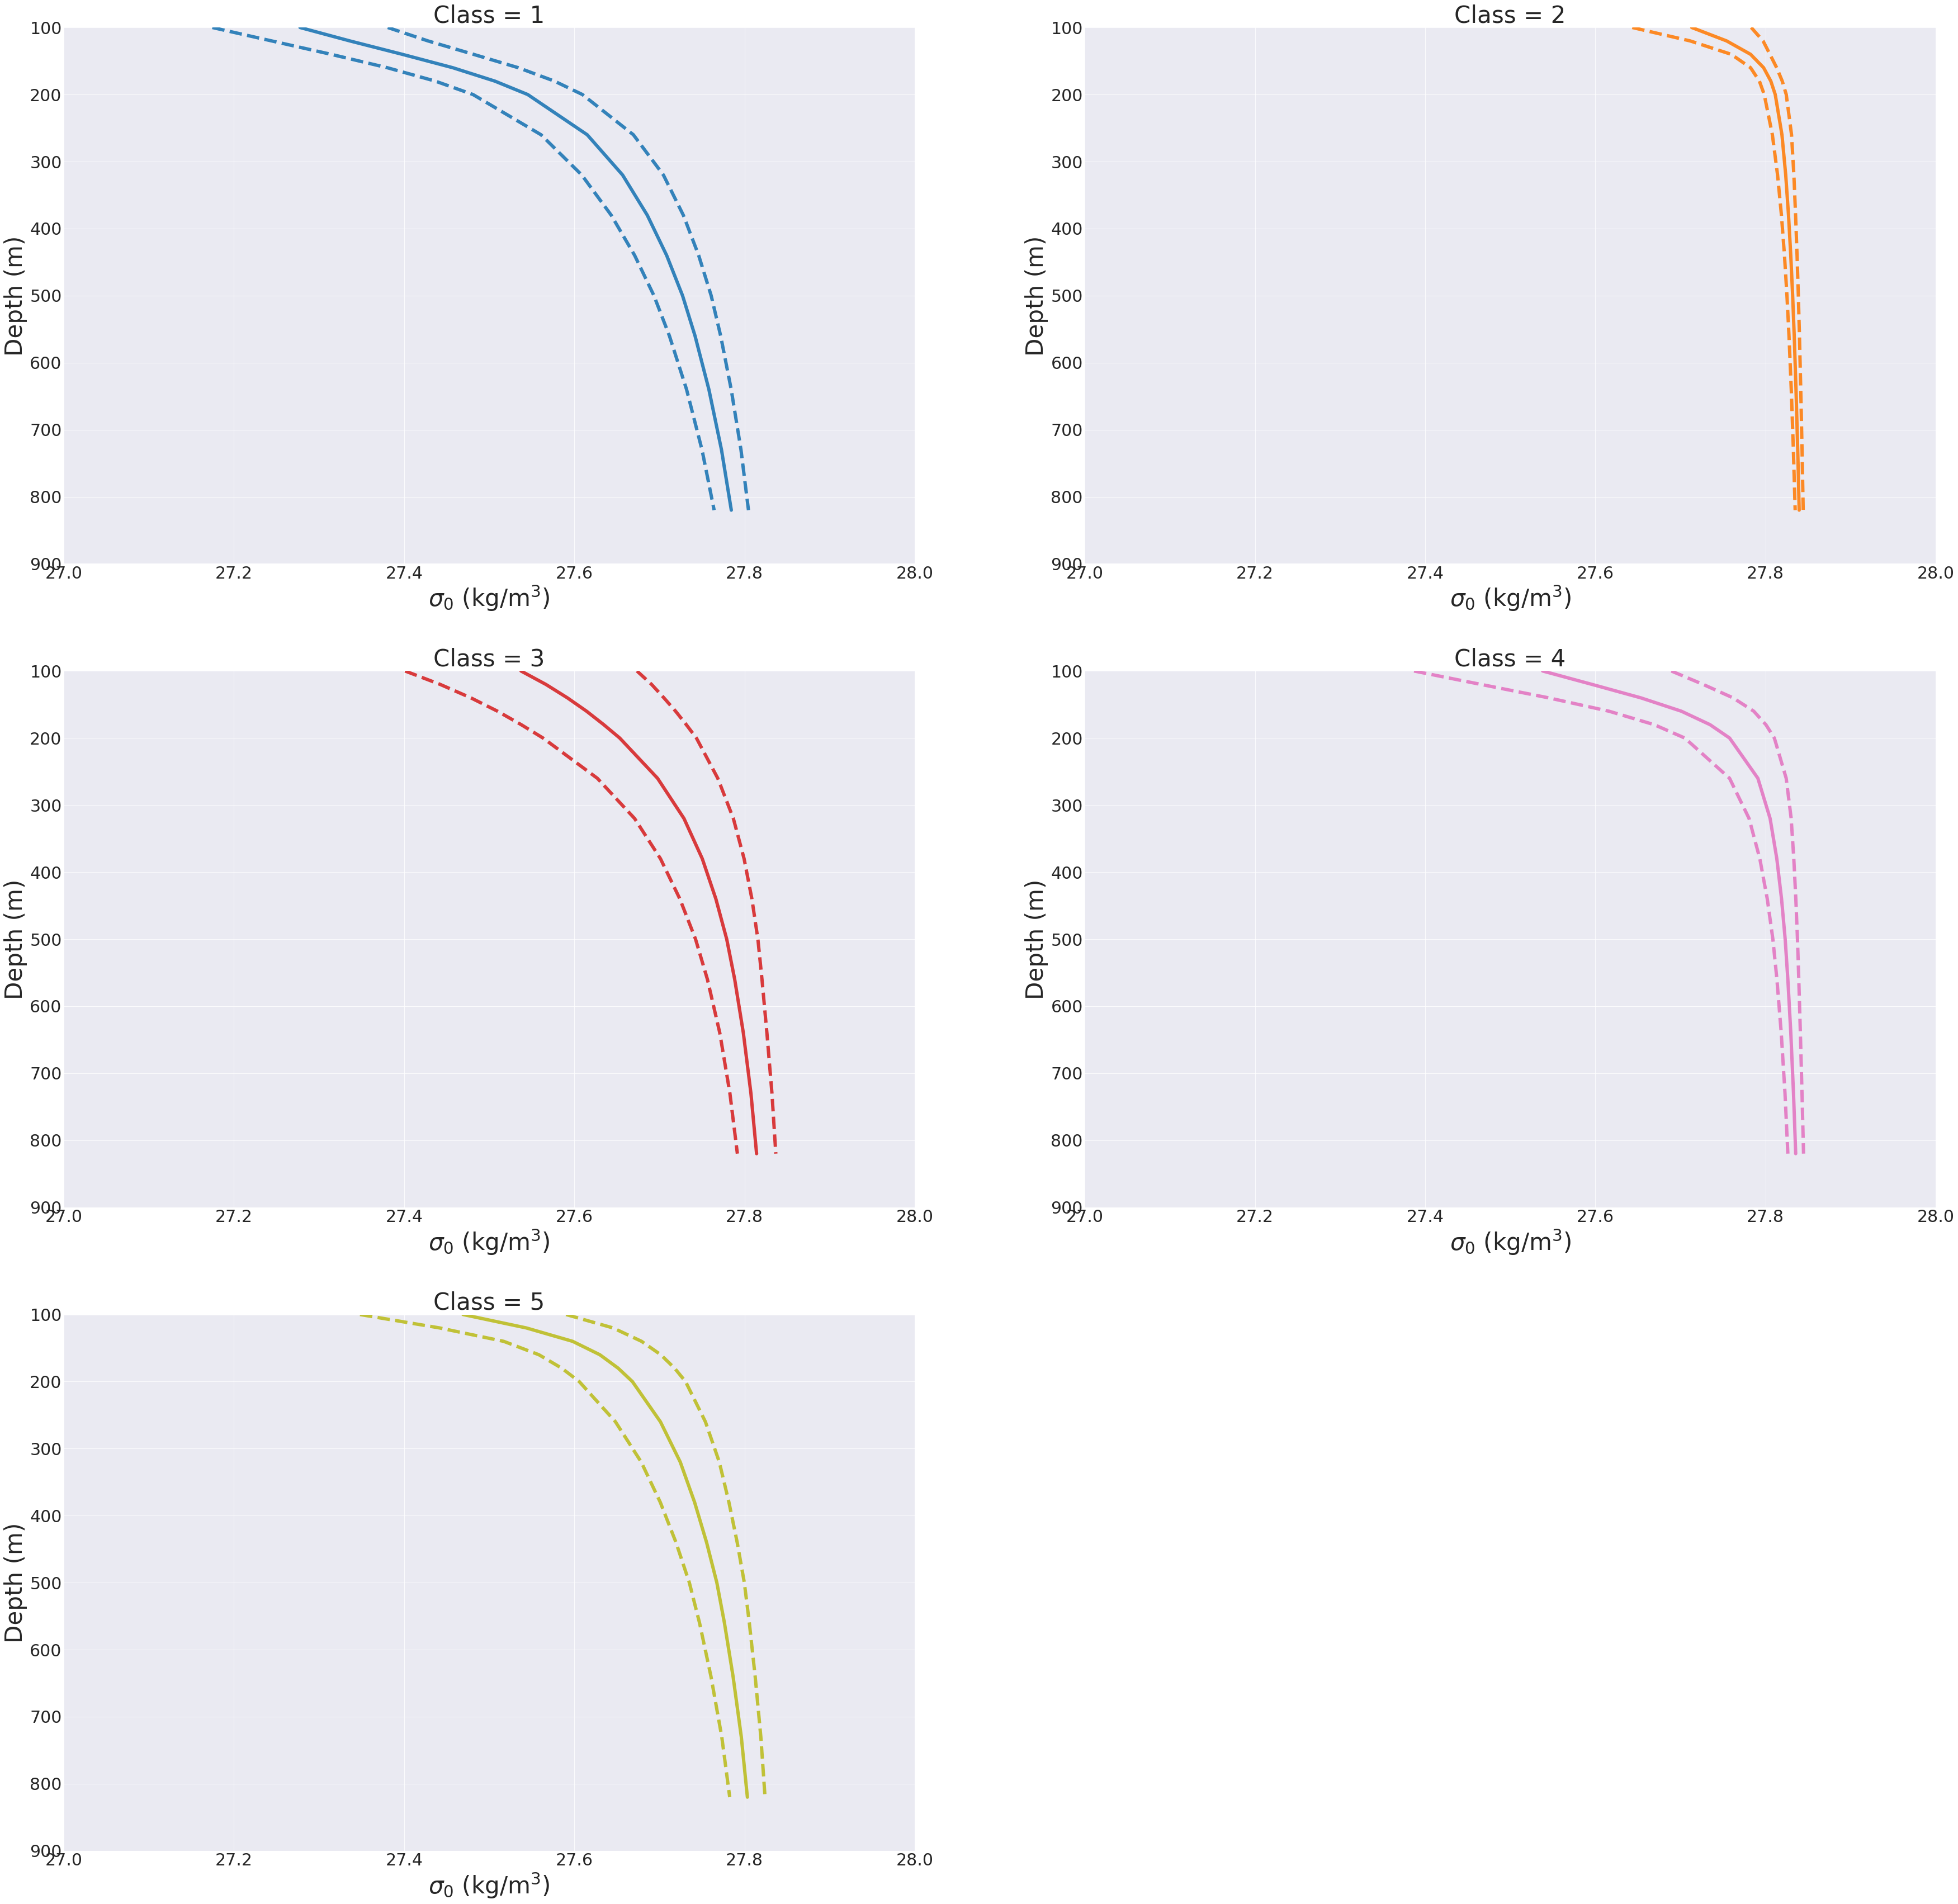

In [26]:
cNorm = colors.Normalize(vmin=0, vmax=n_components_selected)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=colormap)

# initialize the figure
plt.figure(figsize=(60, 60))
plt.style.use('seaborn-darkgrid')
#palette = cmx.Paired(np.linspace(0,1,n_comp))
 
# vertical coordinate
z = profiles_antarctic.depth.values    
    
# iterate over groups
num = 0
for nrow in range(0,n_components_selected):
    num += 1
    colorVal = scalarMap.to_rgba(nrow)
    
    # extract means
    mean_sig0 = class_means.sig0[nrow,:].values
    
    # extract stdevs
    std_sig0 = class_stds.sig0[nrow,:].values
    
    # select subplot
    ax = plt.subplot(3,2,num)
    plt.plot(mean_sig0, z, marker='', linestyle='solid', color=colorVal, linewidth=6.0, alpha=0.9)
    plt.plot(mean_sig0+std_sig0, z, marker='', linestyle='dashed', color=colorVal, linewidth=6.0, alpha=0.9)
    plt.plot(mean_sig0-std_sig0, z, marker='', linestyle='dashed', color=colorVal, linewidth=6.0, alpha=0.9)
    
    # custom grid and axes
    plt.ylim([zmin, zmax])
    plt.xlim([27.0, 28.0])
    
   #text box
    fs = 42 # font size
    plt.xlabel('$\sigma_0$ (kg/m$^3$)', fontsize=fs)
    plt.ylabel('Depth (m)', fontsize=fs)
    plt.title('Class = ' + str(num), fontsize=fs)
    
    # font and axis stuff
    plt.gca().invert_yaxis()
    ax.tick_params(axis='x', labelsize=30)
    ax.tick_params(axis='y', labelsize=30)

### Plot label map

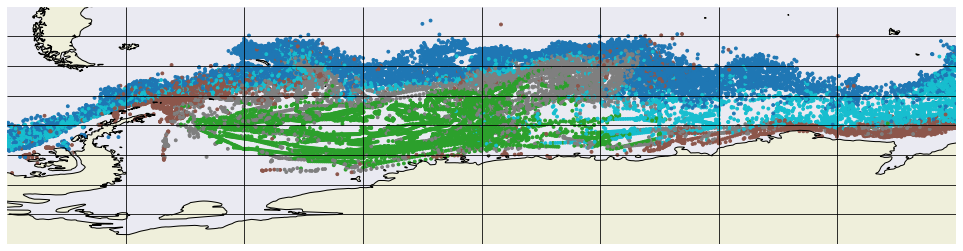

In [41]:
# extract values as new DataArrays
df1D = profiles_antarctic.isel(depth=0)
da_lon = df1D.lon
da_lat = df1D.lat
da_label = df1D.label

# extract values
lons = da_lon.values
lats = da_lat.values
clabels = da_label.values

# size of random sample (all profiles by now)
random_sample_size = int(np.ceil(0.99*df1D.profile.size))

# random sample for plotting
rows_id = random.sample(range(0,clabels.size-1), random_sample_size)
lons_random_sample = lons[rows_id]
lats_random_sample = lats[rows_id]
clabels_random_sample = clabels[rows_id]

#colormap with Historical data
plt.figure(figsize=(17, 13))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, -45], ccrs.PlateCarree())
CS = plt.scatter(lons_random_sample-360, 
                 lats_random_sample, 
                 c=clabels_random_sample,
                 marker='o',
                 cmap= colormap,
                 s=8.0,
                 transform=ccrs.Geodetic(),
                 )
ax.coastlines(resolution='50m')
ax.gridlines(color='black')
ax.add_feature(cartopy.feature.LAND)

## Calculate i-metric

### Define function

In [28]:
# function to calculate the i_metric, label, and runner-up label
def get_i_metric(posterior_prob_list):
    sorted_posterior_list = sorted(posterior_prob_list)
    ic_metric = 1 - (sorted_posterior_list[-1] - sorted_posterior_list[-2])
    runner_up_label = posterior_prob_list.index(sorted_posterior_list[-2])
    label = posterior_prob_list.index(sorted_posterior_list[-1])
    return ic_metric, np.array([label, runner_up_label]) # np.sort()

### Iterate through profiles, calculate i-metric 

In [29]:
# declare variables 
i_metric = np.zeros(df1D.profile.size)
a_b = np.zeros((df1D.profile.size,2))

# loop through the profiles, calculate the i_metric for each one
for i in range(df1D.profile.size):
      i_metric[i], a_b[i,:] = get_i_metric(df1D.posteriors[i, :].values.tolist())
        
# convert i_metric numpy array to xarray DataArray
i_metric = xr.DataArray(i_metric, coords=[profiles_antarctic.profile], dims='profile')

# add i_metric DataArray to Dataset
df1D = df1D.assign({'i_metric':i_metric})

### Plot i-metric by class

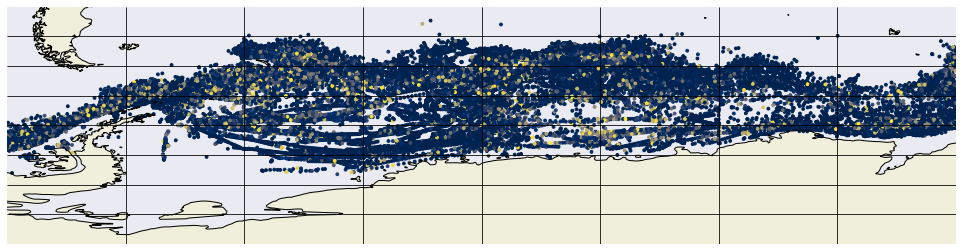

In [30]:
# extract values as new DataArrays
da_lon = df1D.lon
da_lat = df1D.lat
da_i_metric = df1D.i_metric

# extract values
lons = da_lon.values
lats = da_lat.values
c = da_i_metric.values

# random sample for plotting
rows_id = random.sample(range(0,c.size-1), random_sample_size)
lons_random_sample = lons[rows_id]
lats_random_sample = lats[rows_id]
clabels_random_sample = c[rows_id]

#colormap with Historical data
plt.figure(figsize=(17, 13))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, -45], ccrs.PlateCarree())
CS = plt.scatter(lons_random_sample-360, 
                 lats_random_sample, 
                 c=clabels_random_sample,
                 marker='o',
                 cmap= plt.get_cmap('cividis'),
                 s=8.0,
                 transform=ccrs.Geodetic(),
                 )
ax.coastlines(resolution='50m')
ax.gridlines(color='black')
ax.add_feature(cartopy.feature.LAND)

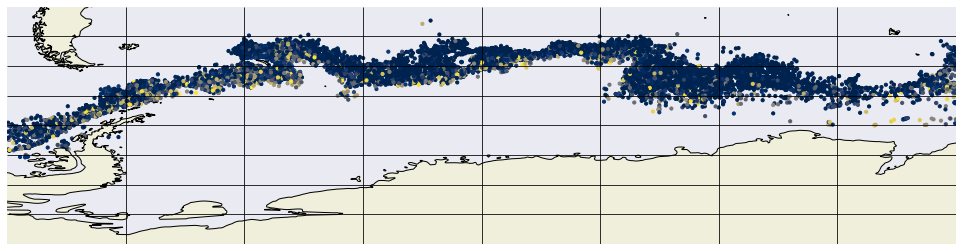

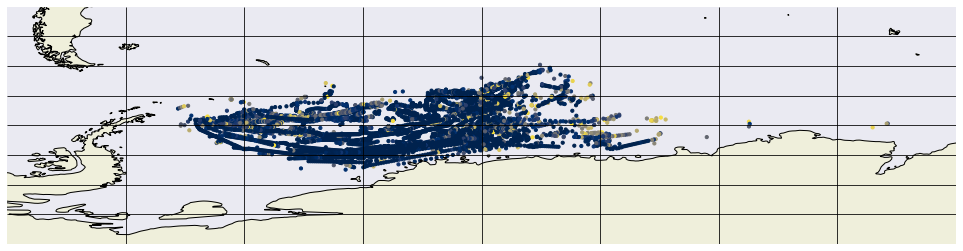

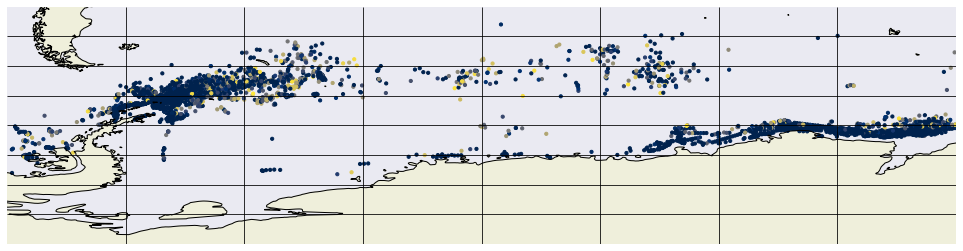

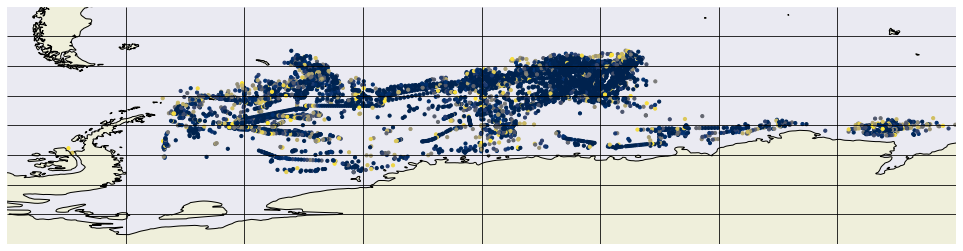

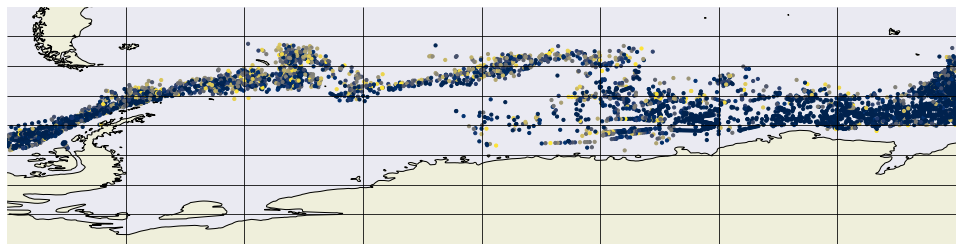

In [31]:
# extract values as new DataArrays
da_lon = df1D.lon
da_lat = df1D.lat
da_i_metric = df1D.i_metric

# extract values
lons = da_lon.values
lats = da_lat.values
c = da_i_metric.values

for iclass in range(n_components_selected):

    # random sample for plotting
    lons_random_sample = lons[labels==iclass]
    lats_random_sample = lats[labels==iclass]
    clabels_random_sample = c[labels==iclass]

    #colormap with Historical data
    plt.figure(figsize=(17, 13))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-80, 80, -85, -45], ccrs.PlateCarree())
    CS = plt.scatter(lons_random_sample-360, 
                     lats_random_sample, 
                     c=clabels_random_sample,
                     marker='o',
                     cmap= plt.get_cmap('cividis'),
                     s=10.0,
                     transform=ccrs.Geodetic(),
                     )
    ax.coastlines(resolution='50m')
    ax.gridlines(color='black')
    ax.add_feature(cartopy.feature.LAND)

Notably, we do seem to have what could be called a "Weddell Gyre class", sort of. It's roughly in the right place; in the core of where the gyre circulation is expected to be. 

Caveats: this is sort of a climatological picture, so to speak. It will be biased towards more recent times, where the density of observations is higher. 

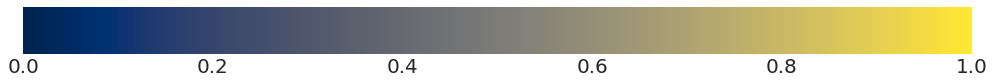

In [32]:
# colorbar all by itself
plt.figure(figsize=(17, 13))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-80, 80, -85, -45], ccrs.PlateCarree())
CS = plt.scatter(lons_random_sample-360, 
                 lats_random_sample, 
                 c=clabels_random_sample,
                 marker='o',
                 cmap= plt.get_cmap('cividis'),
                 s=10.0,
                 transform=ccrs.Geodetic(),
                 )
ax.coastlines(resolution='50m')
ax.gridlines(color='black')
ax.add_feature(cartopy.feature.LAND)
plt.gca().set_visible(False)
cbar = plt.colorbar(orientation='horizontal')
plt.clim(0,1)
cbar.ax.tick_params(labelsize=20)

## Plot classes on T-S diagram

Text(0.5, 1.0, 'T-S diagram at 100.0 dbar')

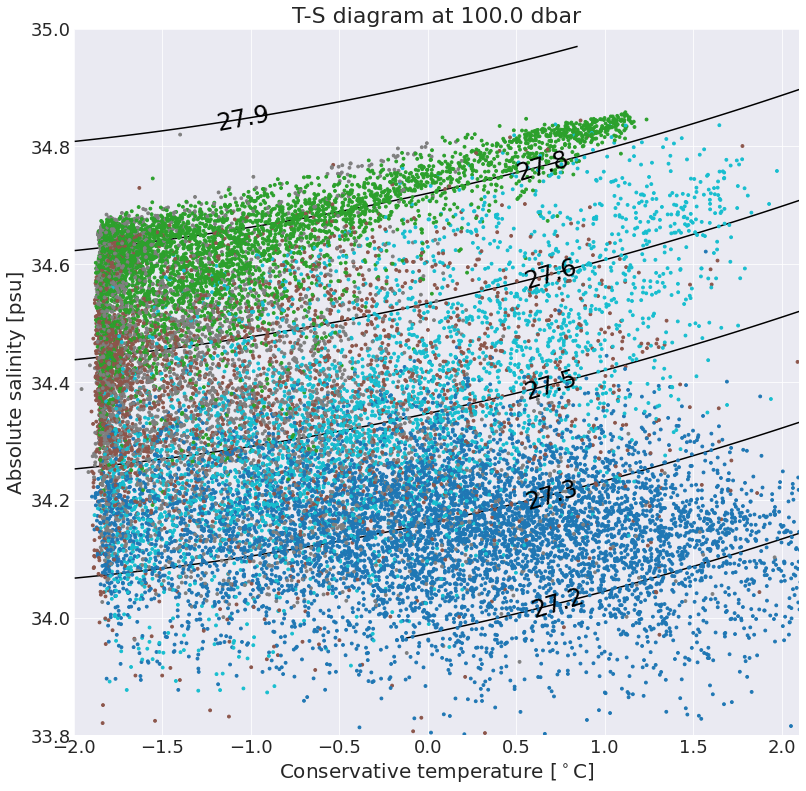

In [33]:
# select depth index
depth_index = 0
df1D = profiles_antarctic.isel(depth=depth_index)

# density for sig0 limits
PTrange = (-2, 2.1)
SPrange = (33.8, 34.8)

# grid
pt_grid = np.linspace(PTrange[0],PTrange[1],100)
sp_grid = np.linspace(SPrange[0],SPrange[1],100)
p = df1D.depth.values
lon = -20 
lat = -65

sa_grid = gsw.SA_from_SP(sp_grid, p, lon, lat)
ct_grid = gsw.CT_from_pt(sa_grid, pt_grid)
ctg,sag = np.meshgrid(ct_grid,sa_grid)
sig0_grid = gsw.density.sigma0(sag, ctg)

# extract values as new DataArrays
T = df1D.prof_CT.values
S = df1D.prof_SA.values
clabels = df1D.label.values

# size of random sample (all profiles by now)
random_sample_size = int(np.ceil(0.60*df1D.profile.size))

# random sample for plotting
rows_id = random.sample(range(0,clabels.size-1), random_sample_size)
T_random_sample = T[rows_id]
S_random_sample = S[rows_id]
clabels_random_sample = clabels[rows_id]

#colormap with Historical data
plt.figure(figsize=(13, 13))
CL = plt.contour(ctg, sag, sig0_grid, colors='black', zorder=1)
SL = plt.clabel(CL, fontsize=24, inline=False, fmt='%.1f')
SC = plt.scatter(T_random_sample, 
                 S_random_sample, 
                 c = clabels_random_sample,
                 marker='o',
                 cmap= colormap,
                 s=8.0,
                 zorder=2,
                 )

plt.xlabel('Conservative temperature [$^\circ$C]', fontsize=20)
plt.ylabel('Absolute salinity [psu]', fontsize=20)
plt.xlim(-2,2.1)
plt.ylim(33.8,35.0)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('T-S diagram at '+ str(p) + ' dbar', fontsize=22)


Text(0.5, 1.0, 'T-S diagram at 200.0 dbar')

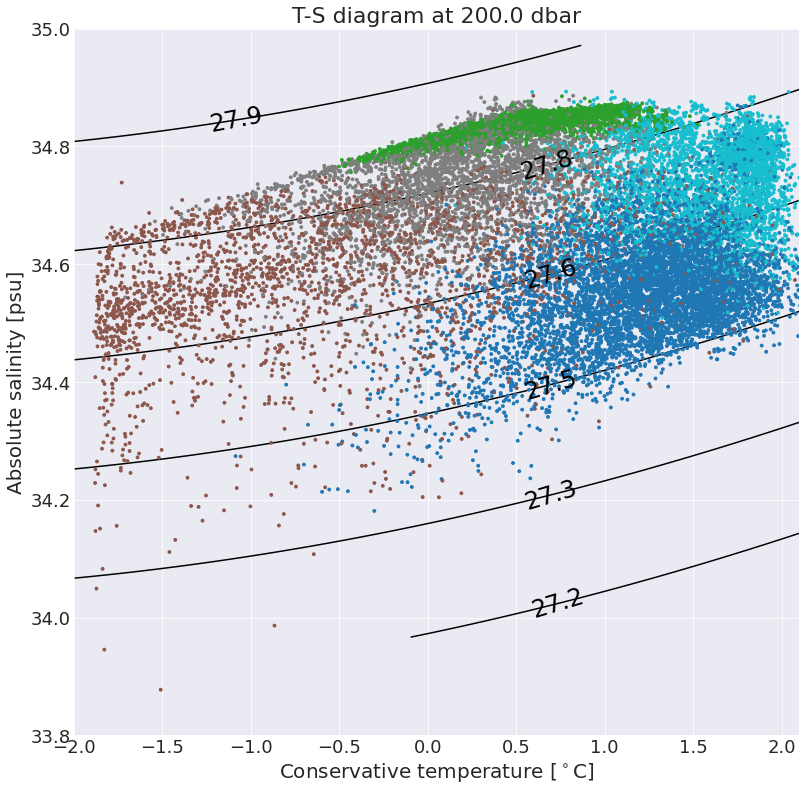

In [34]:
# select depth index
depth_index = 5
df1D = profiles_antarctic.isel(depth=depth_index)

# density for sig0 limits
PTrange = (-2, 2.1)
SPrange = (33.8, 34.8)

# grid
pt_grid = np.linspace(PTrange[0],PTrange[1],100)
sp_grid = np.linspace(SPrange[0],SPrange[1],100)
p = df1D.depth.values
lon = -20 
lat = -65

sa_grid = gsw.SA_from_SP(sp_grid, p, lon, lat)
ct_grid = gsw.CT_from_pt(sa_grid, pt_grid)
ctg,sag = np.meshgrid(ct_grid,sa_grid)
sig0_grid = gsw.density.sigma0(sag, ctg)

# extract values as new DataArrays
T = df1D.prof_CT.values
S = df1D.prof_SA.values
clabels = df1D.label.values

# size of random sample (all profiles by now)
random_sample_size = int(np.ceil(0.60*df1D.profile.size))

# random sample for plotting
rows_id = random.sample(range(0,clabels.size-1), random_sample_size)
T_random_sample = T[rows_id]
S_random_sample = S[rows_id]
clabels_random_sample = clabels[rows_id]

#colormap with Historical data
plt.figure(figsize=(13, 13))
CL = plt.contour(ctg, sag, sig0_grid, colors='black', zorder=1)
SL = plt.clabel(CL, fontsize=24, inline=False, fmt='%.1f')
SC = plt.scatter(T_random_sample, 
                 S_random_sample, 
                 c = clabels_random_sample,
                 marker='o',
                 cmap= colormap,
                 s=8.0,
                 zorder=2,
                 )

plt.xlabel('Conservative temperature [$^\circ$C]', fontsize=20)
plt.ylabel('Absolute salinity [psu]', fontsize=20)
plt.xlim(-2,2.1)
plt.ylim(33.8,35.0)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('T-S diagram at '+ str(p) + ' dbar', fontsize=22)
#plt.colorbar

Text(0.5, 1.0, 'T-S diagram at 500.0 dbar')

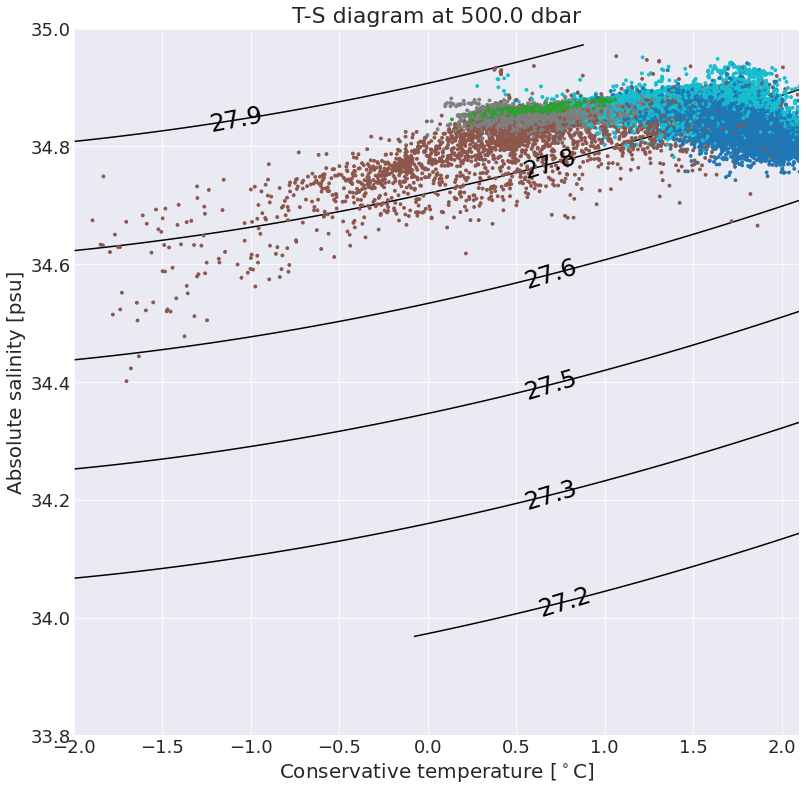

In [35]:
# select depth index
depth_index = 10
df1D = profiles_antarctic.isel(depth=depth_index)

# density for sig0 limits
PTrange = (-2, 2.1)
SPrange = (33.8, 34.8)

# grid
pt_grid = np.linspace(PTrange[0],PTrange[1],100)
sp_grid = np.linspace(SPrange[0],SPrange[1],100)
p = df1D.depth.values
lon = -20 
lat = -65

sa_grid = gsw.SA_from_SP(sp_grid, p, lon, lat)
ct_grid = gsw.CT_from_pt(sa_grid, pt_grid)
ctg,sag = np.meshgrid(ct_grid,sa_grid)
sig0_grid = gsw.density.sigma0(sag, ctg)

# extract values as new DataArrays
T = df1D.prof_CT.values
S = df1D.prof_SA.values
clabels = df1D.label.values

# size of random sample (all profiles by now)
random_sample_size = int(np.ceil(0.60*df1D.profile.size))

# random sample for plotting
rows_id = random.sample(range(0,clabels.size-1), random_sample_size)
T_random_sample = T[rows_id]
S_random_sample = S[rows_id]
clabels_random_sample = clabels[rows_id]

#colormap with Historical data
plt.figure(figsize=(13, 13))
CL = plt.contour(ctg, sag, sig0_grid, colors='black', zorder=1)
SL = plt.clabel(CL, fontsize=24, inline=False, fmt='%.1f')
SC = plt.scatter(T_random_sample, 
                 S_random_sample, 
                 c = clabels_random_sample,
                 marker='o',
                 cmap= colormap,
                 s=8.0,
                 zorder=2,
                 )

plt.xlabel('Conservative temperature [$^\circ$C]', fontsize=20)
plt.ylabel('Absolute salinity [psu]', fontsize=20)
plt.xlim(-2,2.1)
plt.ylim(33.8,35.0)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('T-S diagram at '+ str(p) + ' dbar', fontsize=22)

Text(0.5, 1.0, 'T-S diagram at 820.0 dbar')

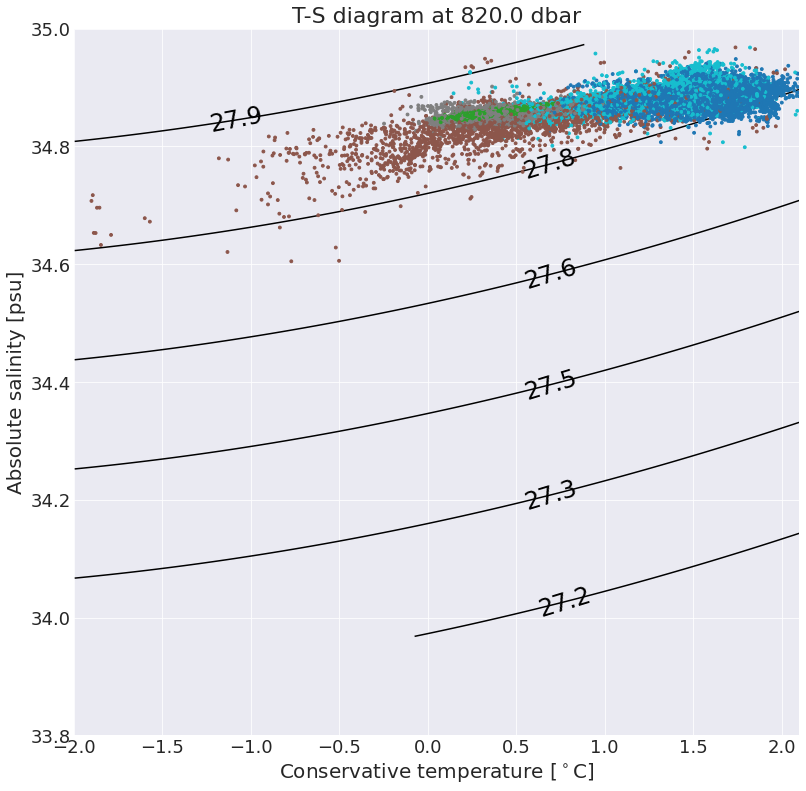

In [36]:
# select depth index
depth_index = 14
df1D = profiles_antarctic.isel(depth=depth_index)

# density for sig0 limits
PTrange = (-2, 2.1)
SPrange = (33.8, 34.8)

# grid
pt_grid = np.linspace(PTrange[0],PTrange[1],100)
sp_grid = np.linspace(SPrange[0],SPrange[1],100)
p = df1D.depth.values
lon = -20 
lat = -65

sa_grid = gsw.SA_from_SP(sp_grid, p, lon, lat)
ct_grid = gsw.CT_from_pt(sa_grid, pt_grid)
ctg,sag = np.meshgrid(ct_grid,sa_grid)
sig0_grid = gsw.density.sigma0(sag, ctg)

# extract values as new DataArrays
T = df1D.prof_CT.values
S = df1D.prof_SA.values
clabels = df1D.label.values

# size of random sample (all profiles by now)
random_sample_size = int(np.ceil(0.60*df1D.profile.size))

# random sample for plotting
rows_id = random.sample(range(0,clabels.size-1), random_sample_size)
T_random_sample = T[rows_id]
S_random_sample = S[rows_id]
clabels_random_sample = clabels[rows_id]

#colormap with Historical data
plt.figure(figsize=(13, 13))
CL = plt.contour(ctg, sag, sig0_grid, colors='black', zorder=1)
SL = plt.clabel(CL, fontsize=24, inline=False, fmt='%.1f')
SC = plt.scatter(T_random_sample, 
                 S_random_sample, 
                 c = clabels_random_sample,
                 marker='o',
                 cmap= colormap,
                 s=8.0,
                 zorder=2,
                 )

plt.xlabel('Conservative temperature [$^\circ$C]', fontsize=20)
plt.ylabel('Absolute salinity [psu]', fontsize=20)
plt.xlim(-2,2.1)
plt.ylim(33.8,35.0)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('T-S diagram at '+ str(p) + ' dbar', fontsize=22)

In [37]:
# can we now plot all the class 2 profiles onto a single T/S diagram? I guess we know what it will show.

In [38]:
profiles_antarctic

<xarray.Dataset>
Dimensions:        (CLASS: 5, depth: 15, profile: 35709, sig0_levs: 8)
Coordinates:
  * profile        (profile) int64 14 15 16 17 ... 185602 185603 185609 185610
    lon            (profile) float64 -26.44 -22.37 -17.38 ... 51.89 64.79 35.28
    lat            (profile) float64 -55.98 -56.81 -57.51 ... -58.72 -60.98
  * depth          (depth) float64 100.0 120.0 140.0 160.0 ... 640.0 730.0 820.0
    time           (profile) datetime64[ns] 1973-01-11T12:00:00 ... 2017-08-2...
  * CLASS          (CLASS) int64 0 1 2 3 4
  * sig0_levs      (sig0_levs) float64 27.4 27.46 27.51 ... 27.69 27.74 27.8
Data variables:
    prof_date      (profile) float64 7.206e+05 7.206e+05 ... 7.369e+05 7.369e+05
    prof_YYYYMMDD  (profile) float64 1.973e+07 1.973e+07 ... 2.017e+07 2.017e+07
    prof_HHMMSS    (profile) float64 1.2e+05 1.2e+05 1.2e+05 ... 8.4e+04 1.4e+04
    prof_T         (profile, depth) float64 -1.228 -0.9877 ... 1.167 1.067
    prof_S         (profile, depth) float64 34.2 34.25 34.33 ... 34.73 34.72
    label          (profile) int64 3 2 0 0 0 3 3 3 2 2 4 ... 0 0 0 0 0 0 0 0 0 0
    posteriors     (profile, CLASS) float64 2.475e-08 2.329e-42 ... 0.4934
    sig0           (profile, depth) float64 27.52 27.55 27.6 ... 27.82 27.82
    prof_SA        (profile, depth) float64 34.36 34.41 34.49 ... 34.9 34.89
    prof_CT        (profile, depth) float64 -1.225 -0.9843 ... 1.167 1.067
    theta_on_sig0  (profile, sig0_levs) float64 nan nan nan ... 1.421 1.43
    salt_on_sig0   (profile, sig0_levs) float64 nan nan nan ... 34.82 34.89

In [39]:
# for iclass in range(n_components_selected):

#     # random sample for plotting
#     lons_plot = profiles_antarctic.lons[labels==iclass]
#     lats_plot = lats[labels==iclass]
#     clabels_plot = c[labels==iclass]

#     #colormap with Historical data
#     plt.figure(figsize=(10, 10))
#     ax = plt.axes(projection=ccrs.PlateCarree())
#     ax.set_extent([-80, 80, -85, -45], ccrs.PlateCarree())
#     CS = plt.scatter(lons_random_sample-360, 
#                      lats_random_sample, 
#                      marker='o',
#                      cmap= plt.get_cmap('cividis'),
#                      s=10.0,
#                      transform=ccrs.Geodetic(),
#                      )
#     ax.coastlines(resolution='50m')
#     ax.gridlines(color='black')
#     ax.add_feature(cartopy.feature.LAND)